In [1]:
from datetime import datetime, timedelta
import pickle
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import re

from tldextract import extract
import langid

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 50)

from newspaper import Article
import matplotlib.pyplot as plt

<ipython-input-1-cd00b3c2a068>:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


NOTE: Mediacloud news for state-specific collection includes news ABOUT the particular state, and as such, might sometimes contain news from national outlets where the article itself might be focused on the state itself. Most (if not all) of the collection is going to be sourced from local state-specific outlets, but not always. Currently, we are keeping all URLs within the obtained collection for the state, except those from nytimes and foxnews since those are our chosen national outlets. Trusting mediacloud's collections to be truly state-focused even when urls come from national outlets. 

In [2]:
start_date = datetime.strptime('2023-01-01', '%Y-%m-%d').date()
end_date = datetime.strptime('2023-12-31', '%Y-%m-%d').date()

In [3]:
texas_news = pd.read_csv('data/mediacloud_texas.csv')
print(texas_news.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5122 entries, 0 to 5121
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   archived_url  5122 non-null   object
 1   article_url   5122 non-null   object
 2   id            5122 non-null   int64 
 3   language      5122 non-null   object
 4   media_name    5122 non-null   object
 5   media_url     5122 non-null   object
 6   publish_date  5122 non-null   object
 7   title         5122 non-null   object
 8   url           5122 non-null   object
dtypes: int64(1), object(8)
memory usage: 360.3+ KB
None


In [4]:
#analyze the distribution across months of publication -- are there gaps in the collection?
all_dates = list(texas_news['publish_date'])
month_to_vol = {}
for i in range(1, 13):
    month_to_vol[i] = 0
for d in tqdm(all_dates):
    m = int(d.split('-')[1])
    month_to_vol[m] += 1

100%|██████████| 5122/5122 [00:00<00:00, 913208.29it/s]


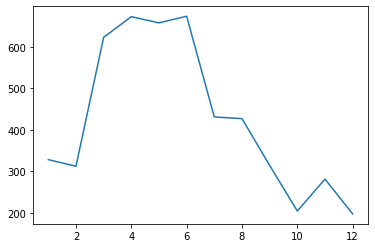

In [5]:
plt.plot(list(month_to_vol.keys()), list(month_to_vol.values()))

In [6]:
texas_news[['language', 'media_name', 'media_url', 'publish_date', 'title', 'url']].tail(20)

,language,media_name,media_url,publish_date,title,url
5102,en,tpr.org,http://tpr.org,2023-04-26 00:00:00,Texas agriculture department's new dress code is based on 'biological gender',https://www.tpr.org/government-politics/2023-04-26/texas-agriculture-departments-new-dress-code-is-based-on-biological-gender
5103,en,tpr.org,http://tpr.org,2023-05-18 00:00:00,"Bill banning puberty blockers, hormone treatments for trans kids sent to Texas governor",https://www.tpr.org/government-politics/2023-05-18/bill-banning-puberty-blockers-hormone-treatments-for-trans-kids-sent-to-texas-governor
5104,en,tpr.org,http://tpr.org,2023-05-29 00:00:00,Here’s the status of some of the most important bills in this year’s Texas Legislature,https://www.tpr.org/government-politics/2023-05-29/heres-the-status-of-some-of-the-most-important-bills-in-this-years-texas-legislature
5105,en,tpr.org,http://tpr.org,2023-08-15 00:00:00,Lawsuit to block Texas' ban on care for transgender youth has its first day in court,https://www.tpr.org/government-politics/2023-08-15/lawsuit-to-block-texas-ban-on-care-for-transgender-youth-has-its-first-day-in-court
5106,en,tpr.org,http://tpr.org,2023-08-31 00:00:00,Texas’ ban on gender-affirming care will take effect Friday following state Supreme Court ruling,https://www.tpr.org/government-politics/2023-08-31/texas-ban-on-gender-affirming-care-will-take-effect-friday-following-state-supreme-court-ruling
5107,en,tpr.org,http://tpr.org,2023-09-01 00:00:00,"Texas adds 774 new laws to the books, and they are now in effect",https://www.tpr.org/government-politics/2023-09-01/texas-adds-774-new-laws-to-the-books-and-they-are-now-in-effect
5108,en,tpr.org,http://tpr.org,2023-09-15 00:00:00,"After a decade of state-led attacks, Texas seeks to bankrupt Planned Parenthood",https://www.tpr.org/government-politics/2023-09-15/after-a-decade-of-state-led-attacks-texas-seeks-to-bankrupt-planned-parenthood
5109,en,tpr.org,http://tpr.org,2023-09-23 00:00:00,Hays County district clerk drops lawsuit against the county's district attorney,https://www.tpr.org/government-politics/2023-09-23/hays-county-district-clerk-drops-lawsuit-against-the-countys-district-attorney
5110,en,tpr.org,http://tpr.org,2023-09-27 00:00:00,Texas will investigate whether foster care officials reap travel rewards from vulnerable youth,https://www.tpr.org/government-politics/2023-09-27/foster-care-officials-benefit-off-backs-of-vulnerable-youth-court-doc-alleges
5111,en,tpr.org,http://tpr.org,2023-12-07 00:00:00,5 major takeaways — and one thing missing — from the fourth Republican debate,https://www.tpr.org/government-politics/2023-12-07/5-major-takeaways-and-one-thing-missing-from-the-fourth-republican-debate


In [7]:
relevant_news = texas_news[~texas_news['media_name'].isin(['foxnews.com',
                                                           'nytimes.com'])]
relevant_news = relevant_news[relevant_news['language']=='en']
relevant_news = relevant_news[['media_name', 'publish_date', 'title', 'url']]
print(relevant_news.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5117 entries, 0 to 5121
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   media_name    5117 non-null   object
 1   publish_date  5117 non-null   object
 2   title         5117 non-null   object
 3   url           5117 non-null   object
dtypes: object(4)
memory usage: 199.9+ KB
None


In [8]:
relevant_news.publish_date = pd.to_datetime(relevant_news.publish_date)
relevant_news = relevant_news[relevant_news['publish_date'].dt.date >= start_date]
relevant_news = relevant_news[relevant_news['publish_date'].dt.date <= end_date]
print(relevant_news.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5117 entries, 0 to 5121
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   media_name    5117 non-null   object        
 1   publish_date  5117 non-null   datetime64[ns]
 2   title         5117 non-null   object        
 3   url           5117 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 199.9+ KB
None


In [9]:
def get_article_from_url(url):
    try:
        article = Article(url)
        article.download()
        article.parse()
        subtitle = article.meta_description
        if subtitle == '' or subtitle == ' ':
            subtitle = None
        text = article.text
        if text == '' or text == ' ':
            text = None
    except:
        subtitle = None
        text = None
    return subtitle, text

In [10]:
subtitles, texts = [], []
all_urls = list(relevant_news['url'])
for url in tqdm(all_urls):
    subtitle, text = get_article_from_url(url)
    subtitles.append(subtitle)
    texts.append(text)
relevant_news['subtitle'] = subtitles
relevant_news['text'] = texts
print(relevant_news.info())

100%|██████████| 5117/5117 [1:10:22<00:00,  1.21it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5117 entries, 0 to 5121
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   media_name    5117 non-null   object        
 1   publish_date  5117 non-null   datetime64[ns]
 2   title         5117 non-null   object        
 3   url           5117 non-null   object        
 4   subtitle      3340 non-null   object        
 5   text          3680 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 279.8+ KB
None


In [11]:
relevant_news.to_csv('data/texas_article_texts_and_info.csv',
                     index=False)